# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка данных

In [1]:
pip install -U scikit-learn -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik -q

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import ( StandardScaler, 
                                    PolynomialFeatures)
from sklearn.linear_model import LinearRegression, Lasso, Ridge,LogisticRegression


from sklearn.metrics import mean_squared_error,r2_score
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
#import my_function as fc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest,f_classif, mutual_info_classif  
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.dummy import DummyRegressor, DummyClassifier


plt.rcParams["figure.figsize"] = (7,7)

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
test_size=0.25

In [4]:
# ---------------Функции--------------
# поиск пропусков
def nan_search(datalist):
    for k, v in datalist.items():
        print(k,'\n')
        print(v.isna().sum())
        print('-'*50)

#поиск дубликатов
def dublic_search(datalist):
    for k, v in datalist.items():
        print(k,'\n')
        print(v.duplicated().sum())
        print('-'*50)


# функция для построения графиков разбиных на категориальные step =1, и количественные step=2
def analysis(df, step:int):
    if step==1:
        for i in df.select_dtypes(include='object').columns:
            print('-----',i,'-----')
            print(df[i].value_counts())
            print()
            pie(df[i].value_counts(), i);
    if step==2:
        for i in df.select_dtypes(exclude='object').columns:
            print('------',i,'---------')
            print(df[i].describe())
            print()
            boxhist(data=df, x=i, title=i);

# ящик с усами

# функция для построения ящика с усами и хистограмы для просмотра распределения
def boxhist(data, x, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(ax=axes[0],data=data, x=x,palette="crest");
    axes[0].set_xlabel(title)
    axes[0].set_title(title)


    sns.histplot(ax=axes[1],data=data, x=x, kde=True, palette="crest");
    axes[1].set_title(title);
    axes[1].set_xlabel(title)
    axes[1].axvline(data[x].mean(), c='k', ls='-', lw=2.5)
    axes[1].axvline(data[x].median(), c='orange', ls='--', lw=2.5)
    plt.xlabel(title);
    plt.show()
# Функция для замены выбросов на значения "усов"
def emissions(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = 1.5 * (q3 -q1)
    df.loc[df[column]>q3+iqr, column]=q3+iqr
    df.loc[df[column]<q1-iqr, column]=q1-iqr
    return df




# Функция сплита данных
def split(df, target):    
    X =df.drop([target], axis=1)
    y=df[target]
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=test_size, random_state =RANDOM_STATE)
    poly = PolynomialFeatures(2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    X_train = pd.DataFrame(X_train_poly,columns = poly.get_feature_names_out())
    X_test = pd.DataFrame(X_test_poly,columns = poly.get_feature_names_out())
    return X_train, X_test, y_train, y_test

In [5]:
# Загрузим данные
try: 
    data_0 = pd.read_csv('C:/Users/Serg/practicum/project_2/dataset/geo_data_0.csv')
    data_1 = pd.read_csv('C:/Users/Serg/practicum/project_2/dataset/geo_data_1.csv')
    data_2 = pd.read_csv('C:/Users/Serg/practicum/project_2/dataset/geo_data_2.csv')
except:  
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Удалим столбцы с id.

In [12]:
data_0 = data_0.drop(['id'],axis=1)
data_1 = data_1.drop(['id'],axis=1)
data_2 = data_2.drop(['id'],axis=1)

Загрузили и просмотрели данные. Теперь проверим на пропуски и дубликаты.

### Предобработка данных

Поиск пропусков.

In [13]:
datalist = {'1 район':data_0,'2 район':data_1,'3 район':data_2}
# фукция для поиска пропусков
nan_search(datalist) 

1 район 

f0         0
f1         0
f2         0
product    0
dtype: int64
--------------------------------------------------
2 район 

f0         0
f1         0
f2         0
product    0
dtype: int64
--------------------------------------------------
3 район 

f0         0
f1         0
f2         0
product    0
dtype: int64
--------------------------------------------------


Пропусков нет.

Поиск дубликатов

In [14]:
#функция для поиска дубликатов
dublic_search(datalist)

1 район 

0
--------------------------------------------------
2 район 

0
--------------------------------------------------
3 район 

0
--------------------------------------------------


Явных дубликатов не найденно

**Вывод** 

Провели предобработку данных. Пропусков и дубликатов нет. 

### Исследовательский анализ данных

------ f0 ---------
count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64



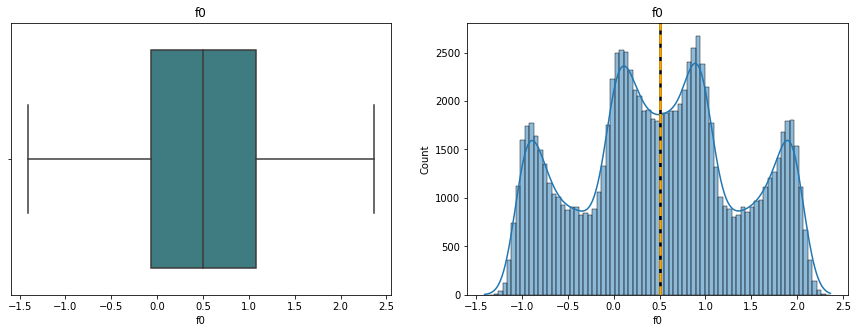

------ f1 ---------
count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64



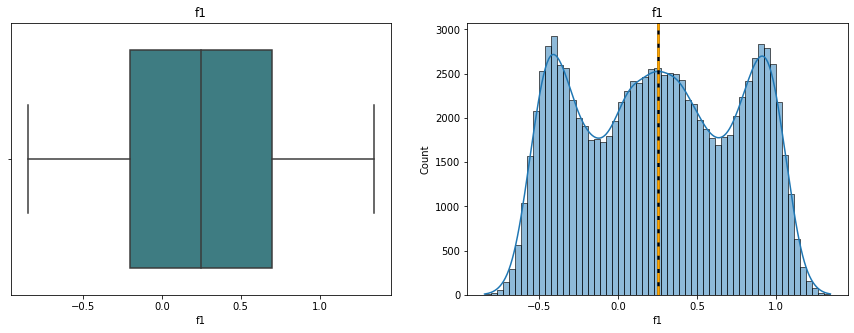

------ f2 ---------
count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64



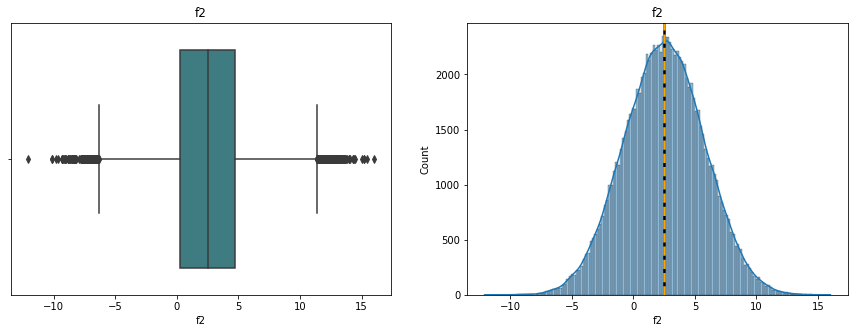

------ product ---------
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64



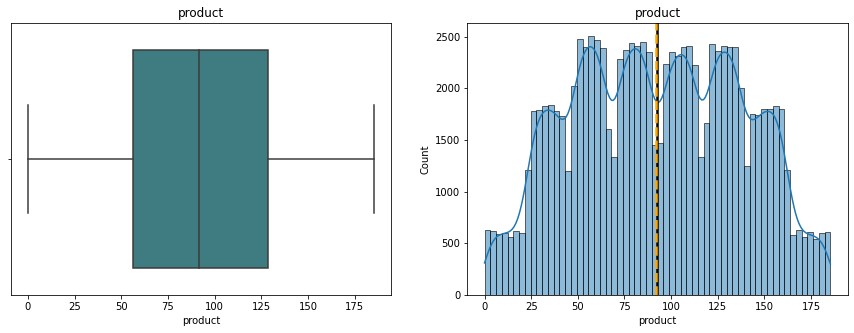

In [15]:
analysis(data_0, step=2)

Признак `f2` имеет нормальное распределение и выбросы

------ f0 ---------
count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64



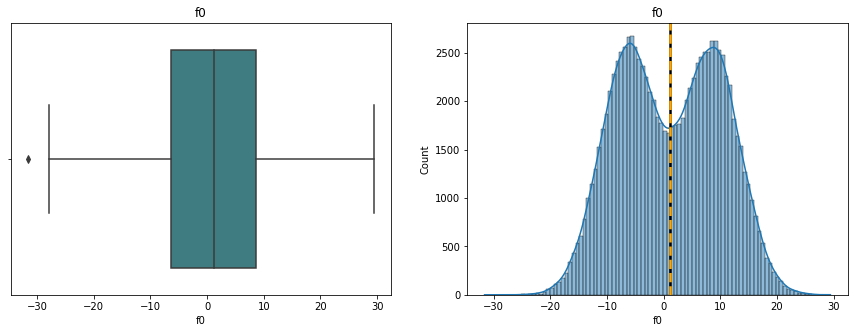

------ f1 ---------
count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64



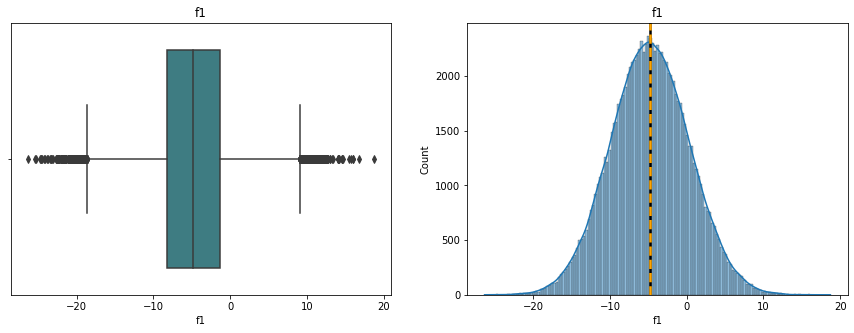

------ f2 ---------
count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64



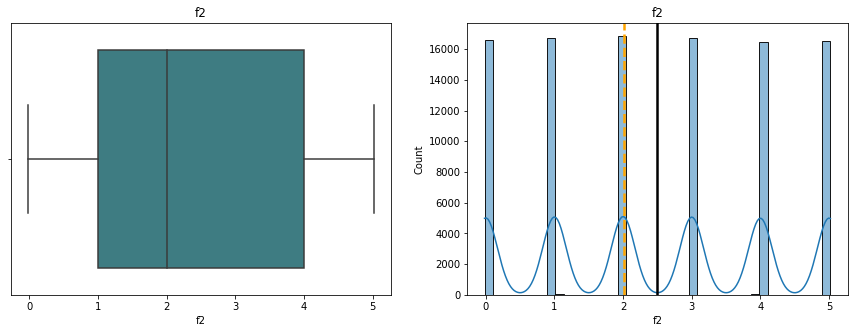

------ product ---------
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64



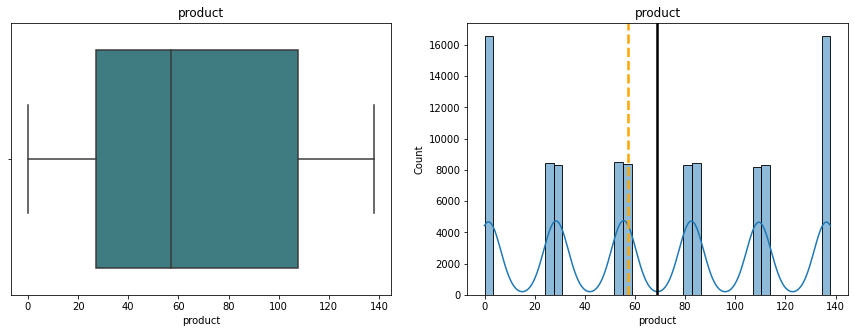

In [16]:
analysis(data_1, step=2)

признаки `f0` и `f1` имеют выбросы
Видим что в столбце `product` и `f2` аномалию в данных

In [17]:
data_1.loc[data_1['product']==0]

,f0,f1,f2,product
11,16.320755,-0.562946,-0.001783,0.0
13,6.695604,-0.749449,-0.007630,0.0
62,21.418478,-5.134490,-0.002836,0.0
63,6.822701,3.104979,-0.000723,0.0
77,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...
99936,5.085749,-3.980305,0.005063,0.0
99948,8.277805,-9.178818,0.003275,0.0
99956,13.343983,-1.290200,0.005980,0.0
99961,13.854163,-11.528089,-0.005556,0.0


В этих данных много нулевых значений ~ 8%. удалим их

In [18]:
data_1 = data_1[data_1['product']!=0]

Присутствует много нулевых значений. Ненормально распределение данных столбце `f2`. При сравнении с данными по другим районам делаем вывод что-либо этот район плохо исследован, либо данные были утеряны.

In [19]:
data_1 = data_1[data_1['product'] > 0]

------ f0 ---------
count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64



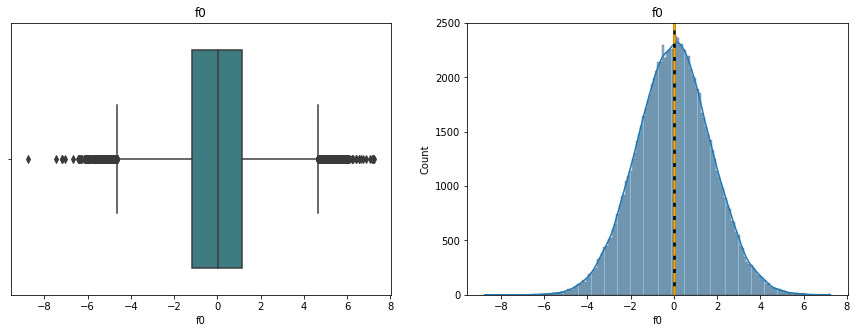

------ f1 ---------
count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64



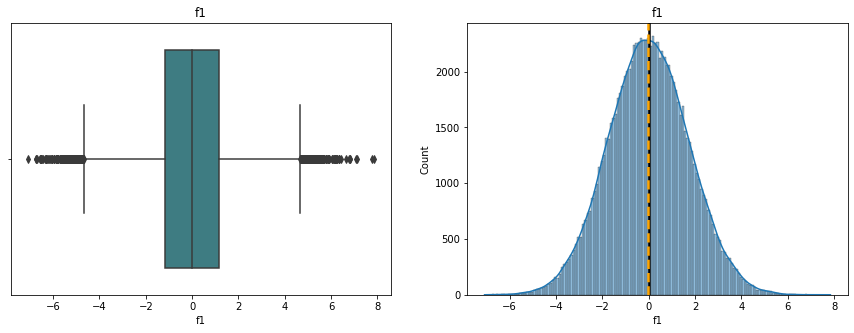

------ f2 ---------
count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64



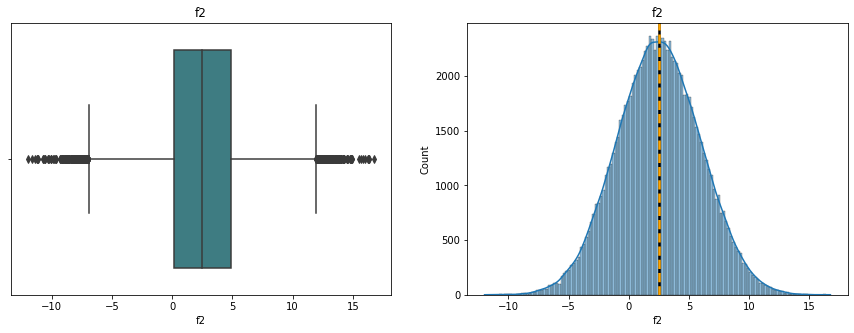

------ product ---------
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64



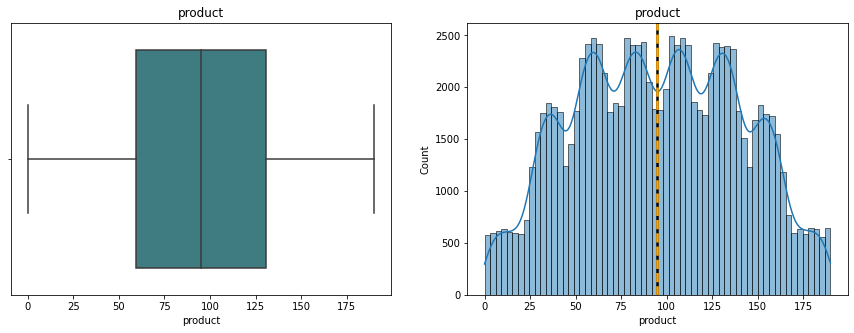

In [20]:
analysis(data_2, step=2)

Все входные признаки имеют выбросы и нормальное распределение

In [21]:
# Заменим выбросы на значения "усов"
emissions(data_0, 'f2')
numlist =['f0', 'f1', 'f2']
for i in numlist:
    emissions(data_2, i)


### Корреляционный анализ

In [22]:
numlist =['f0', 'f1', 'f2', 'product']
cf = data_0.phik_matrix(interval_cols=numlist) 
cf.style.background_gradient(cmap='Blues')

,f0,f1,f2,product
f0,1.000000,0.762170,0.002001,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.002001,0.000000,1.000000,0.482555
product,0.215525,0.253544,0.482555,1.000000


Мультиколлинеарность не наблюдается

In [23]:

cf = data_1.phik_matrix(interval_cols=numlist) 
cf.style.background_gradient(cmap='Blues')

,f0,f1,f2,product
f0,1.000000,0.195034,0.265285,0.670184
f1,0.195034,1.000000,0.069251,0.205966
f2,0.265285,0.069251,1.000000,0.978935
product,0.670184,0.205966,0.978935,1.000000


Присутсвует мультиколлинеарность. Во время подготовки данных удалим столбец f2 

In [24]:

cf = data_2.phik_matrix(interval_cols=numlist) 
cf.style.background_gradient(cmap='Blues')

,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.235537
f1,0.000000,1.000000,0.009576,0.235158
f2,0.000000,0.009576,1.000000,0.449355
product,0.235537,0.235158,0.449355,1.000000


Мультиколлинеарность не наблюдается

### Подготовка данных

In [25]:
# удалим  столбец с мультиколлинеарностью
#data_1 =data_1.drop(['f2'],axis=1)
# объявим список количественных признаков
numlist =['f0', 'f1', 'f2','f0^2','f0 f1','f0 f2','f1^2','f1 f2','f2^2']


In [26]:
preprocessor = ColumnTransformer(
    [
    ('num', StandardScaler(), numlist)
    ], 
    remainder='passthrough') 

In [27]:
pipe_model = Pipeline(
    [('preprocessor', preprocessor),
    ('models', LinearRegression())])

In [28]:
X_train0 ,X_val0, y_train0,y_val0 = split(data_0,'product')
X_train1 ,X_val1, y_train1,y_val1 = split(data_1,'product')
X_train2 ,X_val2, y_train2,y_val2 = split(data_2,'product')

**Вывод** 
- Загрузили и исследовали данные. 
- делаем вывод что-либо этот район плохо исследован, либо данные были утеряны.
- Была проведена подготовка данных обучению.
- создан пай план.
- удалена мультиколлинеарность в данных по 2 району.


## Обучение и проверка модели

### обучение моделей

In [29]:
def model(X_train ,X_val, y_train,y_val):
    pipe_model.fit(X_train, y_train)
    pred = pipe_model.predict(X_val)
    score = mean_squared_error(y_val,pred,squared=False)
    return pred, score

In [30]:
# обучение модели на данных по району №1
pred0, score0 = model(X_train0 ,X_val0, y_train0,y_val0)
score0

37.74255854465207

RMSE модели по первому району -37.7

In [31]:
# повторим обучения для 3 района..
pred2, score2 = model(X_train2 ,X_val2, y_train2,y_val2)

print(score2)

38.76869486087218


RMSE модели по третьему району - 38.8

In [32]:
# обучение модели на данных по району №2
pred1, score1 = model(X_train1 ,X_val1, y_train1,y_val1)
print(score1)

0.8770869492643087


RMSE модели по второму району -0.87

Были обучены модели предсказания объёма нефти.
Лушче всего предказаны данные в  районе №2, rmse - 0.87.

Хуже всего предсказания в районе №3, rmse-38.8.

### Средний запас предсказанного сырья и RMSE модели.

In [33]:
scorelist ={0: score0,1: score1,2: score2}
predlist ={0: pred0,1: pred1,2: pred2}
trulist ={0: y_val0,1: y_val1,2: y_val2}
for i in range(3):
    print(f'Средний запас в районе №{i+1} ={predlist[i].mean()} , RMSE модели {scorelist[i]}')

Средний запас в районе №1 =92.40475146698024 , RMSE модели 37.74255854465207
Средний запас в районе №2 =74.9114262193362 , RMSE модели 0.8770869492643087
Средний запас в районе №3 =94.75969694063907 , RMSE модели 38.76869486087218


**Вывод**

Лучший результат показал модель в районе №2. Хуже всего предсказала модель в районе №3.
Модели ошибаются не более чем на 40 тыс. баррелей.

По среднему запасу лидирует район №3 с запасом 94,8 тыс. баррелей, после идет район №1 с 92 тысячами.

## Подготовка к расчёту прибыли

In [34]:
# Бюджет
BUDGET = 10**10
#исследуем 500 точек
TOTAL_OILWELL =500
# 200 лучших
BEST_OILWELL =200
# цена за 1000 баррель
PRICE = 450 *10**3

In [35]:
summa = BUDGET / BEST_OILWELL
total_bar = summa/PRICE
print(f'Для безубыточной разработки новых скважин, каждая скважина должна приносить -{summa/1000000} млн. рублей')
print(f'Запас нефти в скважене безубыточной разработки {total_bar:.1f} тыс. баррелей')

for key, values in datalist.items():
    print(f'Средний запас нефти в {key}e равен {values["product"].mean():.1f}')
    print(f'Кол-во скважин в {key}e для безубычной разработки {len(values.loc[values["product"] > total_bar])}')

Для безубыточной разработки новых скважин, каждая скважина должна приносить -50.0 млн. рублей
Запас нефти в скважене безубыточной разработки 111.1 тыс. баррелей
Средний запас нефти в 1 районe равен 92.5
Кол-во скважин в 1 районe для безубычной разработки 36583
Средний запас нефти в 2 районe равен 68.8
Кол-во скважин в 2 районe для безубычной разработки 16537
Средний запас нефти в 3 районe равен 95.0
Кол-во скважин в 3 районe для безубычной разработки 38178


**Вывод**
- Нашли количество баррелей для безубыточной разработки - 111 тысяч баррелей.
- В каждом районе достаточно скважин для безубыточной разработки.

## Расчёт прибыли и рисков 

In [36]:
# Функция для расчета прибыли
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    #print(selected.sum())
    return PRICE * selected.sum() - BUDGET

Применим технику Bootstrap с 1000 выборок.

In [40]:
def bootstrap(rage,target, probs):
    state = np.random.RandomState(12345)
    values = []
    target = pd.Series(target).reset_index(drop=True)
    probs = pd.Series(probs).reset_index(drop=True)
    for i in range(rage):
        target_subsample = target.sample(n=TOTAL_OILWELL, replace=True, random_state=state)
        probs_subsample = probs[target_subsample.index] 
        values.append(profit(target_subsample,probs_subsample,BEST_OILWELL))
    values = pd.Series(values)
    return values

In [41]:


for i in range(3):
    values = bootstrap(1000,trulist[i],predlist[i] )
    upper = values.quantile(0.975)/10**6
    lower = values.quantile(0.025)/10**6
    mean = values.mean() / 10**6
    risk = len(values.loc[values <0]) / len(values)*100
    print(f"Средняя выручка в районе №{i+1}: {mean:.0f} млн. рублей")
    print(f'95% доверительный интервал от {lower:.0f} млн. руб.  до {upper:.0f} млн. рублей')
    print(f'Риск составляет {risk:.1f}%')


Средняя выручка в районе №1: 435 млн. рублей
95% доверительный интервал от -125 млн. руб.  до 951 млн. рублей
Риск составляет 6.2%
Средняя выручка в районе №2: 760 млн. рублей
95% доверительный интервал от 328 млн. руб.  до 1163 млн. рублей
Риск составляет 0.1%
Средняя выручка в районе №3: 611 млн. рублей
95% доверительный интервал от 96 млн. руб.  до 1168 млн. рублей
Риск составляет 0.6%


Мы отсеиваем район №1, риск потерять деньги 6%.

Для добычи нефти подходят районы №2 и №3.Из них выберем район №2, т.к. самая высокая возможная прибыль при минимальном риске.

Прибыль и риски района №2:
- средняя возможная прибыль 760 млн. рублей с возможной максимальной прибылью в 1163 млн. рублей. 
- риск разработки составляет менее 0,1%.

## Вывод

Были загружены и исследованы данные по 3 районам возможной нефтедобычи.
- проведены поиски пропусков и дубликатов
- построены графики размаха и распределения. Выявлены аномалии в данных по району №2 (возможно утеря данных или недобор данных).
- обработанны выбросы.

Были обучены модели для предсказания объёма нефти в скважинах в каждом районе.
- лучшее предсказание было в 2 районе.
- RMSE модели составило 0,8.
- Худшее предсказание по району №3 - rmse = 38.

Был произведен расчет прибыли и рисков с использованием bootstrap на 1000 выборок.
- Район №1  был отсеян из-за больших рисков убытков, 6%.
- Район №3 показал возможную прибыль меньше чем в районе №2. Так же риски - 0,6%.  
- Район №2 выбран для разработки скважин. bootstrap показал возможную среднею прибыль в 760 млн. рублей.
- 95% доверительный интервал составил от 328 млн. руб. до 1163 млн. рублей
- риск составляет 0.1%
